In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F
from torchvision import models,transforms,datasets
import time
import cv2
from collections import Counter
import random

In [3]:
!tar zxvf images.tar.gz
!tar zxvf annotations.tar.gz

images/
images/boxer_16.jpg


images/chihuahua_165.jpg
images/pug_183.jpg
images/english_setter_1.jpg
images/chihuahua_170.jpg
images/english_cocker_spaniel_17.jpg
images/samoyed_39.jpg
images/Egyptian_Mau_62.jpg
images/samoyed_36.jpg
images/german_shorthaired_3.jpg
images/Ragdoll_183.jpg
images/British_Shorthair_64.jpg
images/american_pit_bull_terrier_57.jpg
images/beagle_120.jpg
images/american_bulldog_174.jpg
images/chihuahua_101.jpg
images/shiba_inu_136.jpg
images/Abyssinian_136.jpg
images/Siamese_201.jpg
images/Abyssinian_85.jpg
images/saint_bernard_145.jpg
images/Siamese_63.jpg
images/leonberger_164.jpg
images/Maine_Coon_126.jpg
images/samoyed_51.jpg
images/Birman_15.jpg
images/english_cocker_spaniel_181.jpg
images/english_cocker_spaniel_128.jpg
images/leonberger_133.jpg
images/english_cocker_spaniel_6.jpg
images/miniature_pinscher_119.jpg
images/american_pit_bull_terrier_27.jpg
images/Abyssinian_37.jpg
images/Bombay_91.jpg
images/Egyptian_Mau_6.jpg
images/Maine_Coon_173.jpg
images/wheaten_terrier_139.jpg
ima

In [4]:
!head annotations/test.txt

Abyssinian_201 1 1 1
Abyssinian_202 1 1 1
Abyssinian_204 1 1 1
Abyssinian_205 1 1 1
Abyssinian_206 1 1 1
Abyssinian_207 1 1 1
Abyssinian_20 1 1 1
Abyssinian_210 1 1 1
Abyssinian_212 1 1 1
Abyssinian_213 1 1 1


In [2]:
!head annotations/trainval.txt

Abyssinian_100 1 1 1
Abyssinian_101 1 1 1
Abyssinian_102 1 1 1
Abyssinian_103 1 1 1
Abyssinian_104 1 1 1
Abyssinian_105 1 1 1
Abyssinian_106 1 1 1
Abyssinian_107 1 1 1
Abyssinian_108 1 1 1
Abyssinian_109 1 1 1


In [3]:
image_folder = "images"
annotation_folder = "annotations"

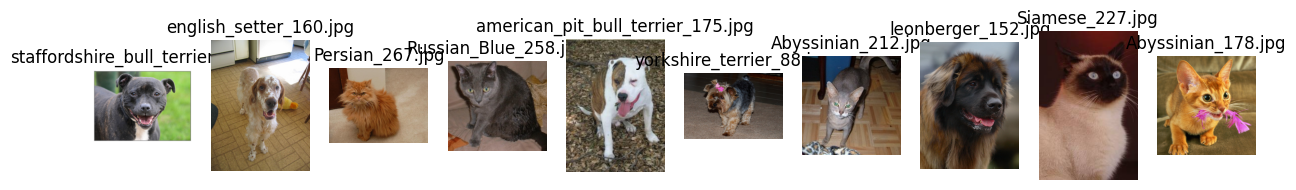

In [4]:
image_files = [f for f in os.listdir(image_folder) if f.endswith(('.jpg', '.png'))]

num_images_to_show = 10
sample_images = random.sample(image_files, min(num_images_to_show, len(image_files)))

plt.figure(figsize=(15,5))
for i, img_name in enumerate(sample_images):
    img_path = os.path.join(image_folder, img_name)
    img = cv2.imread(img_path)[..., ::-1]  # Convert BGR to RGB

    plt.subplot(1, num_images_to_show, i + 1)
    plt.imshow(img)
    plt.axis("off")
    plt.title(img_name)

plt.show()

create 2 directories for test and trainval sets

In [7]:
%mkdir test
%mkdir trainval

Build the model

In [5]:
class CNNModel(nn.Module):
    def __init__(self, num_classes):
        super(CNNModel, self).__init__()
        
        # Convolutional Layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        
        # Pooling Layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Fully Connected (Dense) Layers
        self.fc1 = nn.Linear(128 * 32 * 32, 256)  # Adjust based on image size
        self.fc2 = nn.Linear(256, num_classes)
        
        # Dropout Layer (prevents overfitting)
        self.dropout = nn.Dropout(0.5)
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # Conv1 -> ReLU -> MaxPooling
        x = self.pool(F.relu(self.conv2(x)))  # Conv2 -> ReLU -> MaxPooling
        x = self.pool(F.relu(self.conv3(x)))  # Conv3 -> ReLU -> MaxPooling
        
        x = x.view(x.size(0), -1)  # Flatten
        x = F.relu(self.fc1(x))  # Fully Connected Layer 1
        x = self.dropout(x)  # Apply Dropout
        x = self.fc2(x)  # Output Layer
        
        return x

Prepare the data

#Find average image size

In [7]:
heights = []
widths = []

for img_name in os.listdir(image_folder):
    img_path = os.path.join(image_folder, img_name)
    img = cv2.imread(img_path)
    
    if img is not None:
        h, w, _ = img.shape  # Extract height and width
        heights.append(h)
        widths.append(w)

# Compute average height and width
avg_height = int(np.mean(heights))
avg_width = int(np.mean(widths))

print(f"Average Image Size: {avg_width}x{avg_height}")

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


Average Image Size: 436x391


#Resize images for CNN imput

In [9]:
image_transforms = transforms.Compose([
    transforms.Resize((avg_height, avg_width)), 
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize
])

#Apply resizing to the dataset

In [13]:
class CustomDataset(Dataset):
    def __init__(self, img_dir, annotation_file, transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.data = []
        self.extensions = [".jpg", ".png", ".jpeg"]  # Add supported formats

        with open(annotation_file, "r") as file:
            for line in file:
                parts = line.strip().split()
                if len(parts) > 1:
                    image_name = parts[0]
                    breed = parts[1]
                    
                    # Try finding the correct file extension
                    img_path = None
                    for ext in self.extensions:
                        possible_path = os.path.join(img_dir, image_name + ext)
                        if os.path.exists(possible_path):
                            img_path = possible_path
                            break

                    if img_path:
                        self.data.append((img_path, int(breed)))  # Store path & label
                    else:
                        print(f"Warning: {image_name} not found!")

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path, label = self.data[idx]
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image, label


In [15]:
from torchvision import transforms
from torch.utils.data import DataLoader

image_transforms = transforms.Compose([
    transforms.Resize((avg_width, avg_height)),  # Resize images
    transforms.ToTensor()  # Convert to tensor
])

# Load dataset
dataset = CustomDataset("images", "annotations/trainval.txt", transform=image_transforms)

# Create DataLoader
data_loader = DataLoader(dataset, batch_size=32, shuffle=True)

# Fetch first image
sample_img, sample_label = dataset[0]
print(f"Image Shape: {sample_img.shape}, Label: {sample_label}")


Image Shape: torch.Size([3, 436, 391]), Label: 1


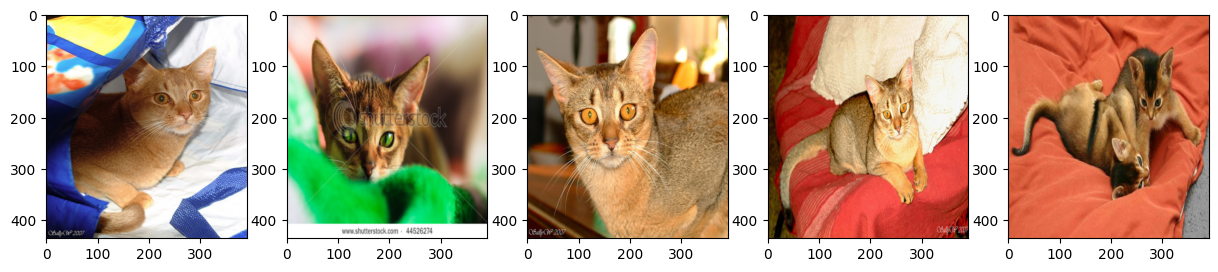

In [17]:
def tensor_to_numpy(tensor):
    image = tensor.numpy().transpose((1, 2, 0))  # Convert CxHxW to HxWxC
    image = np.clip(image, 0, 1)  # Ensure values are between 0 and 1
    return image

# Show a few examples of resized images
num_images_to_show = 5  # Adjust as needed
fig, axes = plt.subplots(1, num_images_to_show, figsize=(15, 5))

for i in range(num_images_to_show):
    img, label = dataset[i]
    img_np = tensor_to_numpy(img)  # Convert tensor to numpy array
    axes[i].imshow(img_np)
    axes[i].axis("on")  

plt.show()